In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV

import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
from hyperopt import hp, tpe, Trials, fmin, space_eval

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [3]:
pd.set_option('display.max_columns', 50)

sns.set()
sns.set_style('whitegrid')

In [4]:
# 警告メッセージを非表示にする
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

今回はPUBGというゲームのデータを使います。  
色々な特徴量からどの特徴量とどの特徴量が相関があるのか、どんなことが言えるか、といった分析  
主にEDAと呼ばれている作業をメインに行おうと思います。 
自由にやってみたので、きれいじゃないです。
データセットは以下のものを用いました。  
https://www.kaggle.com/c/pubg-finish-placement-prediction

In [5]:
train = pd.read_csv('./data/train_V2.csv')
test = pd.read_csv('./data/test_V2.csv')

In [6]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [7]:
train.shape

(4446966, 29)

In [8]:
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

In [9]:
train['matchId'].unique()

array(['a10357fd1a4a91', 'aeb375fc57110c', '110163d8bb94ae', ...,
       '21beed46753ed9', '224a123c53e008', 'fcad6c3fdd847a'], dtype=object)

In [10]:
# 全試合数は 47965 個ある
train['matchId'].nunique()

47965

In [11]:
train['matchId'].value_counts()

85d4421c287d9d    100
59455a480feced    100
7f49b2f144bf03    100
7f58d4bcc49430    100
9e3b3dc28e0adf    100
42f11e0afe84a0    100
f3c14cbf5de636    100
8827fce983763e    100
90ad519f24761f    100
383714611897f7    100
2e99139baa8822    100
b8423039888267    100
045043f888f6a7    100
b808d647e1ca9f    100
da3d9a7ab1b3c1    100
1adfb9000b81c3    100
2a70dd79e7fe6b    100
025dddfb3f9386    100
6b6df7b82bf647    100
7b73434cd26608    100
f521f0f8723298    100
07fabe4f871aa4    100
06a57d307eabe8    100
0784deb07bf0a5    100
c8f22ae0bbc414    100
ca6de556a6ed94    100
60265111ae9527    100
67ba3d368d8c31    100
7ce95d50765a2b    100
f5f0000930b9a4    100
                 ... 
8c889c32f1490e      8
e3c824e12ff949      8
b854116387dfbd      8
378847703cc63b      8
17c643ab998ecb      8
8772c5274a0630      8
cf214bd1cc1dda      8
cedb9e88b4b255      8
8b696c934c5cfc      8
9e7dcc7b9a5162      8
b0cce82af28ea9      8
71af975b5e9a8a      8
66ad63285e8952      7
da121c891ea777      7
bc10cc08f1

### 特徴量の説明
__Id__: プレイヤーのID  
__groupId__: プレイヤーが所属するチームのID  
__matchId__: 試合ごとのID, トレーニングセットとテストセットに共通する試合はない。  
__assits__: 自分がダメージを与えたあとにチームメイトがキルした敵の数  
__boosts__: 使用されたブーストアイテム(体力継続回復や移動速度アップなど)の数  
__damageDealt__: 受けたダメージの量。 セルフダメージは入っていない。  
__DBNOs__: ダウンさせた敵の数(あくまでダウンでキルではない)  
__headshotKills__: ヘッドショットでキルした敵の数  
__heals__: 使った回復アイテムの数  
__killPlace__: 試合のなかで敵をキルした数のランキング  
__killPoints__: プレイヤーのキル数に基づく全体のランキング(試合じゃなく外部の総合として)  
__kills__: 敵プライヤーをキルした数  
__killStreaks__: 短時間で殺害されたプライヤーの最大数(序盤に多いかも)  
__longestKill__: そのプレイヤーが他プレイヤーをキルした時の距離(どれくらい離れていたか)  
__matchDuration__: 試合時間  
__matchType__: 試合の形式を表す。その形式はチームを編成する人数で分かれる。 1人でプレイする"Solo", 2人でプレイする"Duo", 最大4人までプレイする"Squad", "Solo-fpp", "Duo-fpp", "Squad-fpp"などがある。  
__maxPlace__: 最大チーム数(よくわからない)  
__numGroups__: チームの数  
__rankPoints__: このランキングはあまり参考にしない(ゲームの仕様的によくわかっていない？)  
__revives__: そのIdを持つプレイヤーがチームメイトを復活させた回数  
__rideDistance__: 車両で走行した総距離(メートル)  
__roadKills__: 車両に乗っている状態での攻撃でキルした数  
__swimDistance__: 泳いで移動した総距離(メートル)  
__teamKills__: チームメイトをキルした数  
__vehicleDestroys__: 破壊された車両の数  
__walkDistance__: 総走行距離(メートル)  
__weaponsAcquired__: 拾った武器の数  
__winPoints__: プレイヤーの勝利数に基づくランキング(試合じゃなく外部の総合として)  
__winPlacePerc__: ターゲット変数。 1が1位、0が最下位を表す。  

In [12]:
# それぞれのデータ型を調べる
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


In [13]:
# null値があるかどうか確認
train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [14]:
# winPlacePercに1つだけNull値があるのでそれは削除する
train = train.dropna(how='any')

In [15]:
# 再び確認する
train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



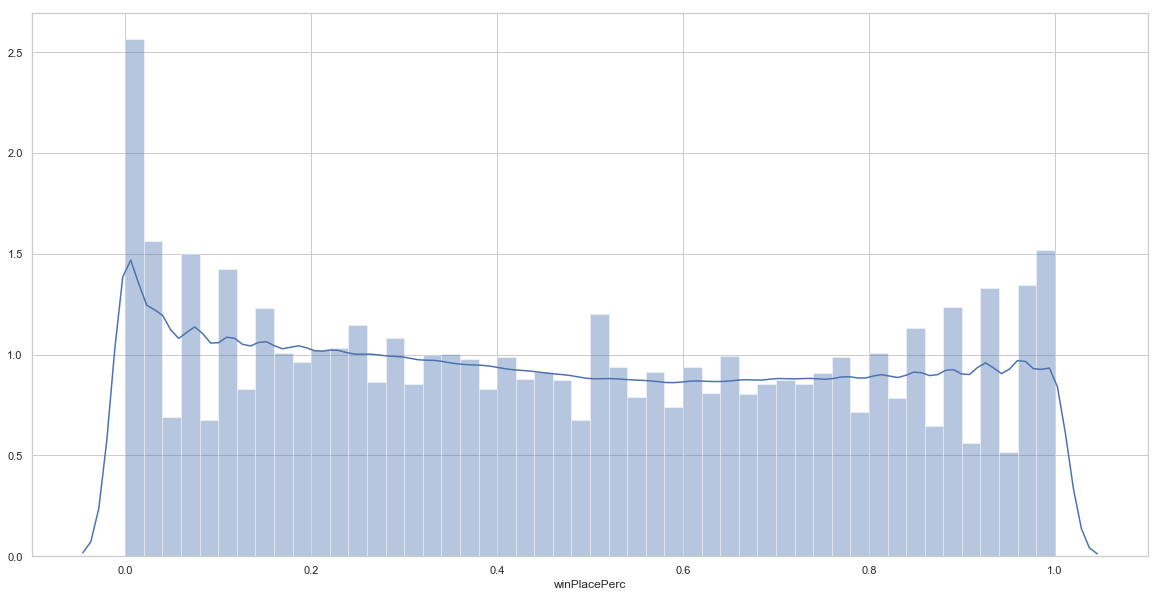

In [16]:
# いろいろ調べていく前に、ターゲット変数である, winPlacePerc の分布がどうなっているか調べる
plt.figure(figsize=(20,10))
sns.distplot(train['winPlacePerc'], bins=50)

分布から、このデータセットはどの勝率も同じような、一様分布に違い分布であることがわかる。  
バイオリンプロットを使って、データの分布とばらつき具合を確認する

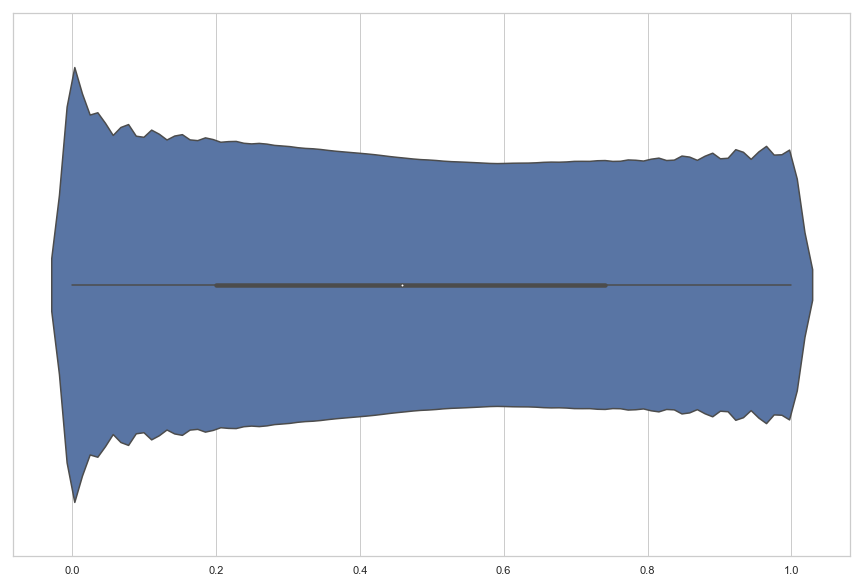

In [10]:
plt.figure(figsize=(15,10))
sns.violinplot(['winPlacePerc'], data=train)

どの勝率の場合も同じような割合かつ、データの中央値は0.45周辺で, それぞれの四分位数も0.25, 0.5, 0.75に近しいものであることがわかる。  
いずれの試合の場合においても、0が最下位で、1が1位を表す。  
先ほど各試合数やそのときのユーザー数をみたが、ほとんどが100人のマッチで  
(中には100人に到達せずに開始される試合や、データとして1試合あたり100人いない場合もある)  
それぞれのマッチで0~1の値が取られるので、全体としても 0 ~ 1の値がまんべんなく取られようだということは予想できる  

In [12]:
zero = train[train['winPlacePerc']==0]

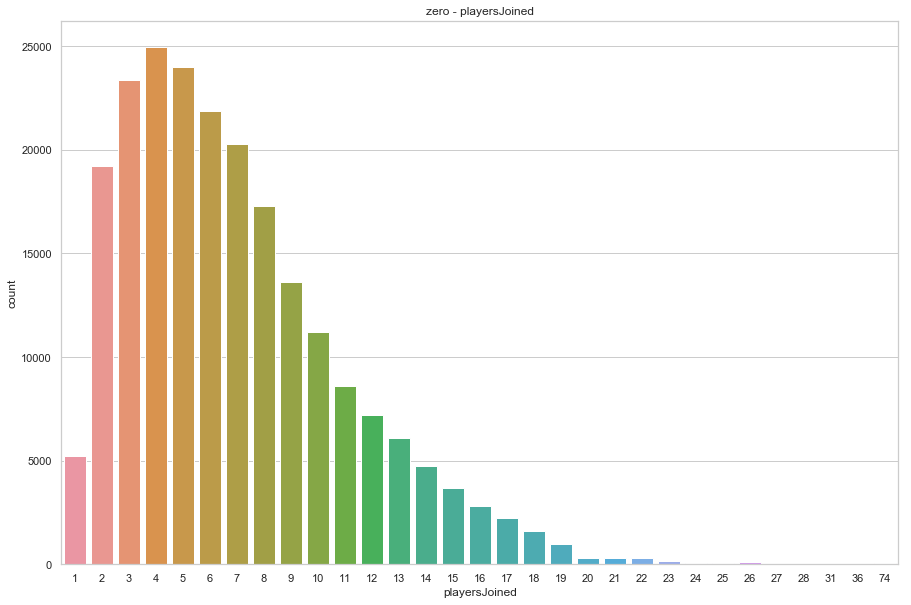

In [13]:
zero['playersJoined'] = zero.groupby('matchId')['matchId'].transform('count')
plt.figure(figsize=(15,10))
sns.countplot(zero['playersJoined'])
plt.title('zero - playersJoined')
plt.show()

In [20]:
train.groupby('matchId')['matchId'].count()

matchId
0000a43bce5eec     95
0000eb01ea6cdd     98
0002912fe5ed71     95
0003b92987589e    100
0006eb8c17708d     93
00077604e50a63     98
00086c74bb4efc     98
00086e740a5804     98
001125344b660c     96
001360264d4b5f     91
0014d9d1b0aff6     94
001616ed5da99b     97
0016fe3ee17ce7     97
00177a6ce4dfb5     92
00188d50e054f5     92
001937f739426c     95
0019bc34b3c58e     97
0019d729577e9c     94
001cd8e7e6b737     24
001e5e4799a31c     92
001e7bc06b1611     59
001eeedf57047a     99
00200fe5d9aae5     99
0022adebf59be6     96
0022e660571ee8     97
00232f9d9c5421     96
0025477f88bbd9     94
002771bd25fe0e     92
0027a504cd3b0c     99
0027b1ffb2e346     17
                 ... 
ffdebe280440e8     86
ffdf8e9dc18596     98
ffdff4a21177ea     92
ffe08b9747a59f     94
ffe21d8fafaf43     96
ffe2a50b7023fb     89
ffe2ee39f210ff     92
ffe6c9fd39b935     98
ffe71c86ca1d81     97
ffe7d37a82297b     98
ffe94ff48407e7     93
ffead5be0b50e8     98
ffeaf5f7073d41     89
ffeb2131284e45     94
ff

プレイヤーが75人以上のマッチがそれぞれいくつあるか、調べる

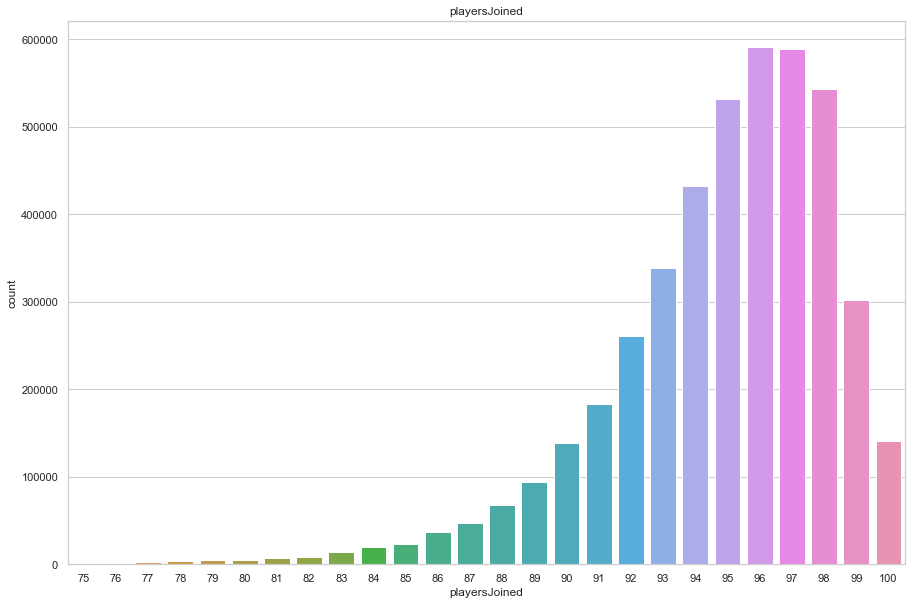

In [15]:
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')
plt.figure(figsize=(15,10))
sns.countplot(train[train['playersJoined'] >= 75]['playersJoined'])
plt.title('playersJoined')
plt.show()

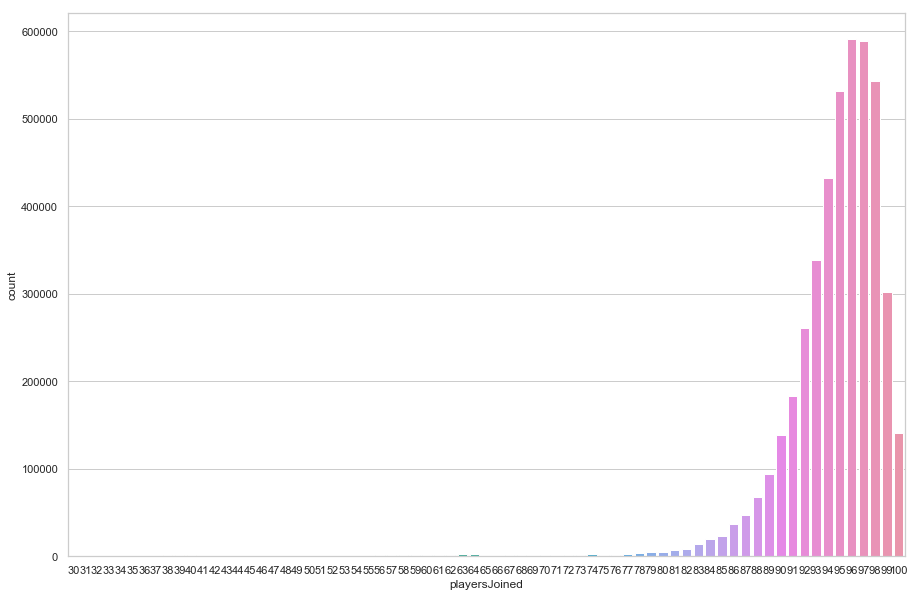

In [18]:
plt.figure(figsize=(15,10))
sns.countplot(train[train['playersJoined']>=30]['playersJoined'])

グラフから、ほとんど100近傍のプレイヤー数でマッチが行われていることがわかる。  
通常100人を想定して行われるゲームのため、  
その中でプレイヤーの動向や予測モデルを立てる際には極端に少ないプレイヤー数のマッチの情報は落とした方がいいかもしれない。  

ここで、とりあえず、不正なプレイがないか調べる。  
たとえば、全く動いていないのに誰かをキルしたプレイヤーがいたりする可能性もあり、それはおそらく不正であることも疑える。  

In [21]:
train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']
train['killsWithoutMoving'] = ((train['kills'] > 0) & (train['totalDistance'] == 0))

In [22]:
train[train['killsWithoutMoving'] == True].shape

(1535, 32)

In [23]:
train[train['killsWithoutMoving'] == True].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killsWithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.0,0,0,3,18,0,6,3,23.540,593,normal-squad-fpp,15,13,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8571,58,0.0,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.6,0,0,6,33,0,3,1,6.523,1794,normal-squad-fpp,11,11,1500,0,0.0,0,0.0,0,0,0.0,22,0,0.6000,42,0.0,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.0,0,4,5,3,0,20,6,37.080,898,normal-solo-fpp,20,15,1500,0,0.0,0,0.0,0,0,0.0,13,0,0.8947,21,0.0,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.8,0,0,0,69,1000,1,1,21.540,799,normal-squad-fpp,19,18,-1,0,0.0,0,0.0,0,0,0.0,7,1500,0.0000,73,0.0,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.0,0,1,0,37,0,1,1,55.430,1794,normal-squad-fpp,11,11,1500,0,0.0,0,0.0,0,0,0.0,10,0,0.3000,42,0.0,True


疑わしいデータが1535件もあることがわかる。  
これらは全く動いていないにも関わらず誰かしらキルしている。  
最初いくら敵が近くに居ようが、武器をもっていないのでキルすることはできないはず  
(殴ることもできるが、殴り殺されるのをわざわざ待つようなプレイヤーはいないだろう)  
というわけでこれらのデータを削除する  

In [24]:
train.drop(train[train['killsWithoutMoving'] == True].index, inplace=True)

また、roadKills という特徴量も重要である。  
もし、roadkillsが多いのにも関わらず、rideDistanceが少ないようなデータが存在していたら疑わしい。  
乗っているだけで誰かをキルするというのももちろん考えられのでそこは注意する。

In [25]:
train[train['roadKills'] > 10]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killsWithoutMoving
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,1403,14,13,7.181,1456,solo,92,80,-1,0,0.005,14,5.297,0,0,1277.0,0,1371,0.4286,92,1282.302,False
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,1497,11,11,0.000,1946,solo,88,77,-1,0,4118.000,11,0.000,0,0,816.6,5,1533,0.4713,88,4934.600,False
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,1114,20,18,64.290,1970,solo,38,20,-1,0,2726.000,18,0.000,0,0,3150.0,4,1568,1.0000,38,5876.000,False
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,1520,18,11,341.400,1925,solo,84,70,-1,0,6812.000,11,0.000,0,0,1041.0,10,1606,0.9398,84,7853.000,False


完全にc3e444f7d1289fは黒である。 rideDistanceがたった0.005にも拘わらず14人ものプレイヤーをキルしている  
他の roadKillsが高いプレイヤーrideDistanceも高い。  

In [27]:
train.drop([2733926], inplace=True)

In [28]:
train[train['roadKills'] > 10]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killsWithoutMoving
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,1497,11,11,0.00,1946,solo,88,77,-1,0,4118.0,11,0.0,0,0,816.6,5,1533,0.4713,88,4934.6,False
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,1114,20,18,64.29,1970,solo,38,20,-1,0,2726.0,18,0.0,0,0,3150.0,4,1568,1.0000,38,5876.0,False
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,1520,18,11,341.40,1925,solo,84,70,-1,0,6812.0,11,0.0,0,0,1041.0,10,1606,0.9398,84,7853.0,False


kills があまりに高いプレイヤーがいないかどうかを調べる  

In [30]:
train[train['kills'] > 30]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killsWithoutMoving
57978,9d8253e21ccbbd,ef7135ed856cd8,37f05e2a01015f,9,0,3725.0,0,7,0,2,1000,35,3,105.80,1798,normal-duo-fpp,8,7,-1,0,0.00,0,0.00,0,0,48.820,48,1500,0.8571,16,48.820,False
87793,45f76442384931,b3627758941d34,37f05e2a01015f,8,0,3087.0,0,8,27,3,1000,31,3,95.34,1798,normal-duo-fpp,8,7,-1,0,0.00,0,0.00,0,0,780.700,45,1500,1.0000,16,780.700,False
156599,746aa7eabf7c86,5723e7d8250da3,f900de1ec39fa5,21,0,5479.0,0,12,7,4,0,48,6,81.95,1798,normal-solo-fpp,11,11,1500,0,0.00,0,0.00,0,0,23.710,61,0,0.7000,11,23.710,False
160254,15622257cb44e2,1a513eeecfe724,db413c7c48292c,1,0,4033.0,0,40,0,1,1000,42,5,266.20,844,normal-squad-fpp,8,8,-1,0,0.00,0,0.00,1,0,718.300,16,1500,1.0000,62,718.300,False
180189,1355613d43e2d0,f863cd38c61dbf,39c442628f5df5,5,0,3171.0,0,6,15,1,0,35,3,102.50,1796,normal-solo-fpp,9,6,1500,0,0.00,0,0.00,0,0,71.510,41,0,1.0000,11,71.510,False
334400,810f2379261545,7f3e493ee71534,f900de1ec39fa5,20,0,6616.0,0,13,5,1,0,65,7,73.90,1798,normal-solo-fpp,11,11,1500,0,0.00,0,0.00,0,0,1036.000,60,0,1.0000,11,1036.000,False
353128,f3e9746e3ff151,4bc1f00f07b304,a9e84c456cc859,2,0,3834.0,0,9,5,1,0,39,3,263.90,1795,normal-solo-fpp,13,10,1500,0,0.00,0,0.00,0,0,124.200,42,0,1.0000,13,124.200,False
457829,265e23756baa0b,9d94424171c2a1,664dee9ed8f646,3,0,2907.0,0,27,2,1,0,33,4,439.20,827,normal-squad,5,5,1500,0,0.00,0,0.00,1,0,382.400,15,0,1.0000,38,382.400,False
488335,31a0682922ef45,275a27a3ee4cc8,3037f74ef8a3a3,2,0,3055.0,0,9,0,1,1000,33,5,97.99,892,normal-solo-fpp,18,14,-1,0,0.00,0,0.00,0,0,35.300,31,1500,1.0000,20,35.300,False
662650,dd424a8b74bd49,ac9dea6d62f2e6,8a728def0644be,9,0,3454.0,38,9,4,1,1000,34,4,124.00,1198,normal-squad-fpp,14,14,-1,0,0.00,0,0.00,0,0,111.100,25,1500,0.2308,54,111.100,False


In [33]:
train['kills'].describe()

count    4.445430e+06
mean     9.232324e-01
std      1.553000e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      7.200000e+01
Name: kills, dtype: float64

playersJoinedよりも多いkillsのデータはどういうことなのだろうか...  
とりあえずそれらは削除する。  
すると、Id: 15622257cb44e2 が残るが、このデータもheadshot_rate を調べると95%という高さである。  
よって真偽は定かではないが、もしいたとしてもそんなプレイヤーは基本的にまずいないので削除しても差し支えはないように思える。  
よってこれらのデータを削除する  

In [35]:
train.drop(train[train['kills'] > 30].index, inplace=True)

In [36]:
train[train['kills'] > 30]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killsWithoutMoving


また、全キル数のうち、ほぼヘッドショットであるような場合も疑わしい。  
熟練したプレイヤーでもなかなかヘッドショットですべて仕留めるというのは難しい、というかほぼ不可能であるように思えるためである。  
もちろんキル数が少なく、それがたまたまヘッドショットのため100%ということもありうるということには注意を払わないといけない。  

In [38]:
train['headshot_rate'] = train['headshotKills'] / train['kills']
train['headshot_rate'] = train['headshot_rate'].fillna(0)

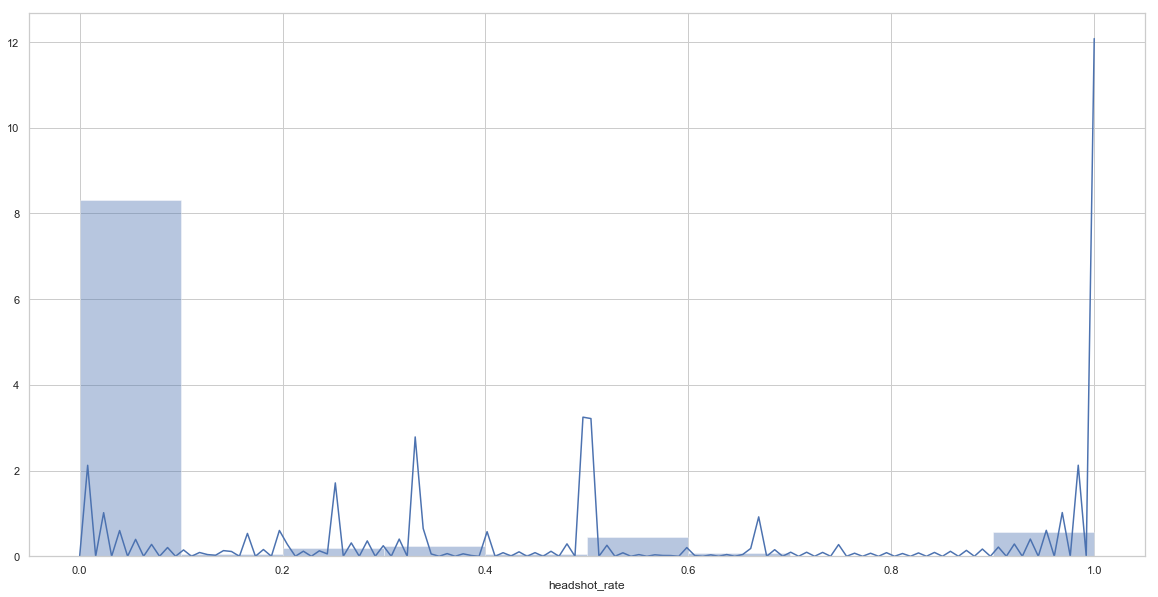

In [39]:
# 図示する
plt.figure(figsize=(20,10))
sns.distplot(train['headshot_rate'], bins=10)

In [40]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killsWithoutMoving,headshot_rate
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,96,244.8000,False,0.0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,91,1445.0445,False,0.0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755,98,161.8000,False,0.0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667,91,202.7000,False,0.0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875,97,49.7500,False,0.0


やはり怪しそうなものがある。  
そこで、ひとまず、headshot_rateが100%かつ、10人以上をキルしているプレイヤーを見てみる  

In [41]:
train[(train['headshot_rate'] == 1) & (train['kills'] > 9)].shape

(24, 33)

In [42]:
train[(train['headshot_rate'] == 1) & (train['kills'] > 9)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killsWithoutMoving,headshot_rate
281570,ab9d7168570927,add05ebde0214c,e016a873339c7b,2,3,1212.0,8,10,0,1,0,10,4,159.20,1423,squad-fpp,27,25,1564,1,0.00,0,0.0,0,0,2939.0,5,0,0.8462,93,2939.00,False,1.0
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,1424,11,2,633.60,1727,squad,27,26,-1,3,4720.00,0,0.0,0,0,3422.0,8,1560,1.0000,96,8142.00,False,1.0
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,1579,13,2,353.80,1255,squad,27,27,-1,0,0.00,0,0.0,0,0,2105.0,5,1587,1.0000,98,2105.00,False,1.0
908815,566d8218b705aa,a9b056478d71b2,3a41552d553583,2,5,1535.0,10,10,3,1,1393,10,3,533.20,1838,squad-fpp,28,24,-1,0,5187.00,0,0.0,2,0,2761.0,7,1519,0.9630,95,7948.00,False,1.0
963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,1543,10,2,277.00,1417,squad,27,26,-1,0,1018.00,0,0.0,0,0,2458.0,4,1562,1.0000,96,3476.00,False,1.0
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,5,1218.0,8,11,3,1,0,11,3,484.90,1821,squad-fpp,28,27,1495,0,5246.00,0,0.0,0,0,2932.0,4,0,1.0000,95,8178.00,False,1.0
1167959,c4f80d4be5c561,b4a7892189b5dd,c7f7733ebbd447,0,4,1065.0,6,10,1,1,1391,10,2,222.00,1246,squad-fpp,27,27,-1,0,408.90,0,0.0,0,0,2450.0,7,1468,1.0000,97,2858.90,False,1.0
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,5,1319.0,11,12,1,1,0,12,2,443.00,1730,squad-fpp,28,28,1560,0,2048.00,0,0.0,0,0,3915.0,5,0,1.0000,93,5963.00,False,1.0
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,4,1150.0,4,11,1,1,1000,11,3,289.60,1248,duo,46,41,0,1,0.00,0,0.0,0,0,3108.0,7,1500,1.0000,88,3108.00,False,1.0
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,10,1478.0,8,13,2,1,0,13,3,95.14,1379,duo-fpp,49,48,1813,0,0.00,0,140.8,0,0,2339.0,4,0,1.0000,96,2479.80,False,1.0


他の特徴量もみると、特に異常に見える値もないため、削除はしないでおく。  
中には longestKill (敵をキルした時の最大距離)が0 というあり得ないデータもあるが。。。  

次に、 longestKill に注目する。  
武器の中で一番遠くまで飛ばせる武器はスナイパーライフルで、さらにその中でも一番飛距離がでる銃が最大で1000mらしい。  
よって longestKill が 1000m以上のデータはおかしいのではないかと疑うことができる。  

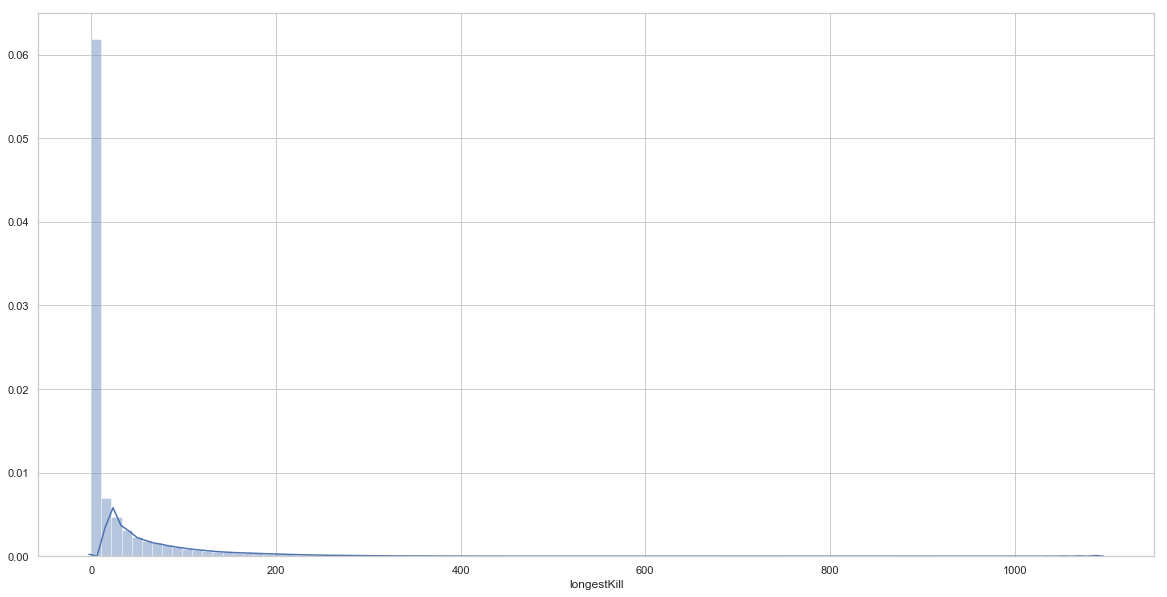

In [43]:
plt.figure(figsize=(20,10))
sns.distplot(train['longestKill'], bins=100)

In [44]:
train[train['longestKill'] > 1000].shape

(18, 33)

In [45]:
train[train['longestKill']>1000].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killsWithoutMoving,headshot_rate
240005,41c2f5c0699807,9faecf87ab4275,634edab75860b3,5,0,1284.0,8,5,7,18,1000,11,2,1004.0,1308,normal-duo-fpp,14,13,-1,1,0.0,0,0.0,0,0,48.87,38,1500,0.5385,29,48.87,False,0.454545
324313,ef390c152bcc3d,30fd444be3bbc1,4f7f8d6cf558b4,2,0,1028.0,0,0,0,9,0,10,2,1026.0,698,normal-squad-fpp,13,13,1500,0,1717.0,0,0.0,0,0,1264.00,26,0,1.0000,51,2981.00,False,0.000000
803632,4e7e6c74e3c57d,94698690918933,da91b0c3d875f8,0,0,196.8,0,0,0,51,0,1,1,1075.0,471,normal-squad-fpp,8,8,1500,0,2085.0,0,0.0,0,0,1074.00,22,0,0.0000,61,3159.00,False,0.000000
895411,1f5ba6e0cfb968,512ea24b831be3,5fb0d8b1fc16cf,4,0,1012.0,11,5,0,5,0,10,3,1094.0,1021,normal-squad-fpp,12,12,1500,0,0.0,0,0.0,0,0,569.50,18,0,0.9091,86,569.50,False,0.500000
1172437,303a93cfa1f46c,8795d39fd0df86,9c8962b58bb3e3,2,1,329.3,0,0,2,45,1000,3,1,1037.0,581,normal-squad-fpp,8,7,-1,0,0.0,0,0.0,0,0,832.50,9,1500,0.2857,58,832.50,False,0.000000


In [46]:
train.drop(train[train['longestKill'] > 1000].index, inplace=True)

In [47]:
train[train['longestKill']>1000].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killsWithoutMoving,headshot_rate


チートの中には高速移動といったものがあるらしい。移動速度をみることはできないが、  
高速移動が可能ならば高速で巡回しまくると考えられるので、移動距離をみてみる。  

In [48]:
train[['walkDistance', 'rideDistance', 'swimDistance', 'totalDistance']].describe()

,walkDistance,rideDistance,swimDistance,totalDistance
count,4.445317e+06,4.445317e+06,4.445317e+06,4.445317e+06
mean,1.154629e+03,6.063296e+02,4.510971e+00,1.765469e+03
std,1.183514e+03,1.498570e+03,3.050771e+01,2.183260e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.554000e+02,0.000000e+00,0.000000e+00,1.584000e+02
50%,6.864000e+02,0.000000e+00,0.000000e+00,7.893000e+02
75%,1.977000e+03,2.612000e-01,0.000000e+00,2.729000e+03
max,2.578000e+04,4.071000e+04,3.823000e+03,4.127010e+04


#### walkDistance

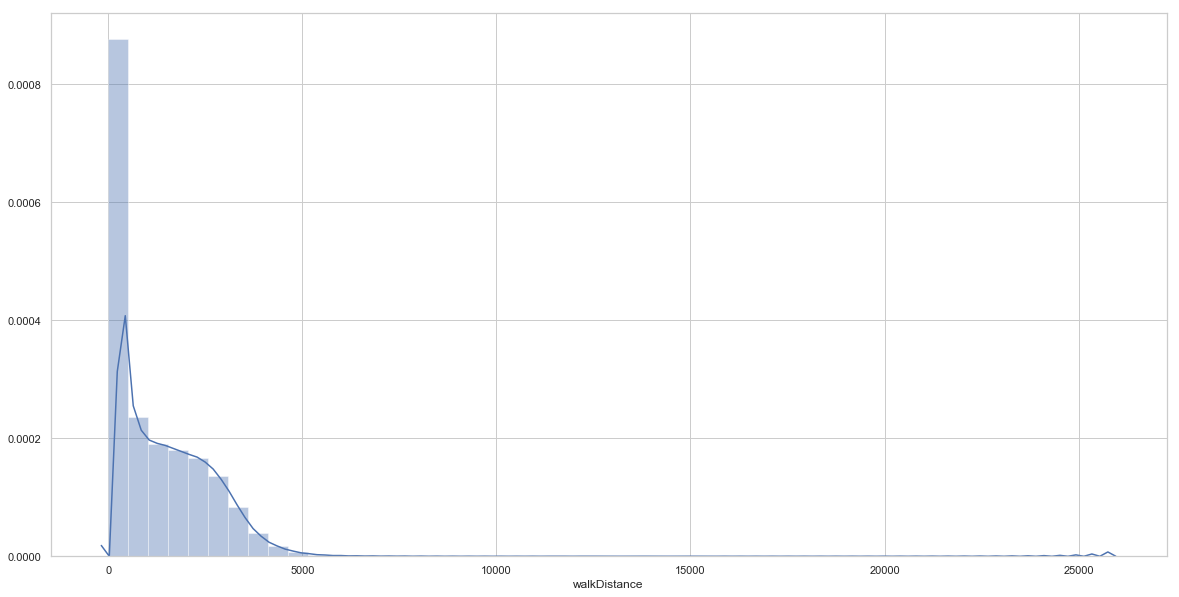

In [49]:
plt.figure(figsize=(20,10))
sns.distplot(train['walkDistance'], bins=50)

In [50]:
# 99%タイルを確認してみる
train['walkDistance'].quantile(0.999)

6206.0

数百万のデータセットもあったうちの99.9%タイルを確認すると、6153.0 ということがわかった。  
これは、99.9%の walkDistance というカラムのデータが 6153.0m までということである。
つまり、歩行距離1万を超えるようなデータは0.11%にも満たないような、それでいてありえないようなデータといえる。  
よってこれらは削除してもいいかもしれない  

In [42]:
train[train['walkDistance'] > 10000].shape

(219, 33)

In [54]:
train[train['walkDistance'] > 10000].head(10)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killsWithoutMoving,headshot_rate
23026,8a6562381dd83f,23e638cd6eaf77,b0a804a610e9b0,0,1,0.00,0,0,0,44,0,0,0,0.000,1906,solo,99,93,1517,0,0.4212,0,9.882,0,0,13530.0,7,0,0.8163,99,13540.3032,False,0.0
34344,5a591ecc957393,6717370b51c247,a15d93e7165b05,0,3,23.22,0,0,1,34,1256,0,0,0.000,1977,squad-fpp,20,20,-1,0,0.0373,0,40.870,0,0,10030.0,7,1533,0.9474,65,10070.9073,False,0.0
49312,582685f487f0b4,338112cd12f1e7,d0afbf5c3a6dc9,0,4,117.20,1,0,1,24,0,1,1,6.823,2192,duo-fpp,47,46,1507,0,0.0088,0,36.750,0,0,12410.0,3,0,0.9130,94,12446.7588,False,0.0
68590,8c0d9dd0b4463c,c963553dc937e9,926681ea721a47,0,1,32.34,0,0,1,46,1378,0,0,0.000,1836,duo-fpp,49,47,-1,0,847.8000,0,45.820,0,0,11590.0,3,1563,0.8333,96,12483.6200,False,0.0
94400,d441bebd01db61,7e179b3366adb8,923b57b8b834cc,1,1,73.08,0,0,3,27,1000,0,0,0.000,1806,solo,73,64,-1,0,1005.0000,0,45.630,0,0,10440.0,6,1488,0.8194,73,11490.6300,False,0.0
125103,db5a0cdc969dcb,50cc466757950e,c306a9745c4c1d,0,4,37.73,0,0,7,47,1000,0,0,0.000,1957,solo,95,93,-1,0,0.0378,0,38.760,0,0,12790.0,5,1500,0.7340,95,12828.7978,False,0.0
136421,955e60b09a96b1,30df08fe22a901,8669d01725f135,0,1,0.00,0,0,1,46,0,0,0,0.000,1973,duo-fpp,47,43,1590,0,1823.0000,0,30.810,0,0,10370.0,3,0,0.6957,94,12223.8100,False,0.0
136476,0d75d05b5c988c,3da040ce77cd0b,65bc5211a569dd,0,3,0.00,0,0,0,41,1370,0,0,0.000,1861,solo-fpp,91,89,-1,0,4581.0000,0,197.200,0,0,10140.0,5,1772,0.9333,91,14918.2000,False,0.0
154080,7e8a71d23381cd,e2c9f4f92840b2,a721de1aa05408,0,3,0.00,0,0,13,46,0,0,0,0.000,1923,solo-fpp,94,89,1476,0,2400.0000,0,16.700,0,0,10220.0,4,0,0.8602,94,12636.7000,False,0.0
154128,32fdde4c716787,390ae9a51c11b8,82610ed1b4d033,0,4,52.16,0,0,7,25,0,1,1,28.310,1836,duo-fpp,48,47,1451,1,0.0314,0,29.830,0,0,10860.0,6,0,0.8936,95,10889.8614,False,0.0


In [55]:
train[train['winPlacePerc'] == 1]['walkDistance'].describe()

count    127362.000000
mean       2969.764899
std         988.458954
min           0.000000
25%        2475.000000
50%        3010.000000
75%        3516.000000
max       15130.000000
Name: walkDistance, dtype: float64

In [56]:
# 生存期間が長いならばkill数も必然的に多くなると考えられるが、kill数も低く、勝率も高いと考えると、高速巡回して流れ弾などにあたって死んだか  
# とりあえずまともに戦闘もしていないようなデータでありそうといえるため、削除する。
train.drop(train[train['walkDistance'] >= 10000].index, inplace=True)

#### rideDistance

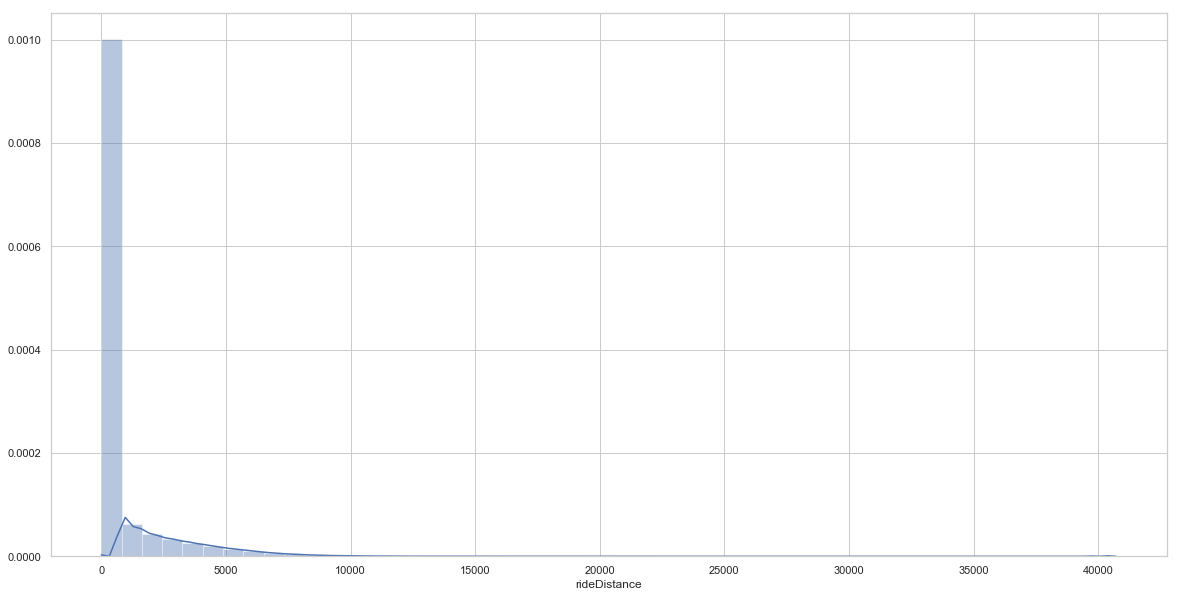

In [45]:
plt.figure(figsize=(20,10))
sns.distplot(train['rideDistance'], bins=50)

In [57]:
# 99%タイルを見てみる
train['rideDistance'].quantile(0.999)

10560.0

99.9% タイルを見てみると、10560.0 であることがわかった。  
先ほどとは違い、バイクなので歩行距離よりも移動距離が長いというのはあるかもしれないが、  
それでも15000以上のデータはおかしいと思われるため、削除する。  

In [58]:
train[train['rideDistance'] >= 15000].shape

(498, 33)

In [59]:
train['rideDistance'].describe()

count    4.445098e+06
mean     6.063248e+02
std      1.498584e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.479750e-01
max      4.071000e+04
Name: rideDistance, dtype: float64

In [48]:
train[train['rideDistance'] >= 15000].head(10)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killsWithoutMoving,headshot_rate
4906,8f05e600c7c8b8,560528edc46d1f,48167b9435e7c1,0,2,16.22,0,0,2,48,1132,0,0,0.000,1816,squad-fpp,29,26,-1,0,17210.0,0,0.0,0,0,624.10,3,1520,0.7500,95,17834.10,False,0.0
16895,6da7b6c5cda276,d2982ffa6a2a3c,f5ec4d90b83c91,0,0,7.53,0,0,0,40,1047,0,0,0.000,1779,solo-fpp,87,85,0,0,15540.0,0,0.0,0,0,635.40,3,1500,0.9419,87,16175.40,False,0.0
28588,6260f7c49dc16f,b24589f02eedd7,6ebea3b4f55b4a,0,0,99.20,0,0,1,30,0,1,1,5.419,1894,solo,96,89,1642,0,25930.0,0,0.0,0,0,376.60,6,0,0.6421,96,26306.60,False,0.0
48084,30abe4cbc9344d,4684bc6d097ae2,3646053157cc0b,0,0,0.00,0,0,2,57,0,0,0,0.000,1962,squad-fpp,28,28,1354,0,17570.0,0,0.0,0,0,237.80,2,0,0.5185,93,17807.80,False,0.0
63015,adb7dae4d0c10a,8ede98a241f30a,8b36eac66378e4,0,0,0.00,0,0,0,55,0,0,0,0.000,1891,solo,94,88,1529,0,21880.0,0,0.0,0,0,185.40,0,0,0.5376,94,22065.40,False,0.0
67147,0dacf80c0b22ca,569c288b7fd2ee,31ae74ad13d5cc,0,0,0.00,0,0,0,51,0,0,0,0.000,1859,squad,29,29,1375,0,15610.0,0,0.0,0,0,55.08,0,0,0.6071,97,15665.08,False,0.0
70507,ca6fa339064d67,f7bb2e30c3461f,3bfd8d66edbeff,0,0,100.00,0,0,0,26,0,1,1,3.924,1928,solo,99,95,1512,0,28450.0,1,0.0,0,0,467.50,3,0,0.8878,99,28917.50,False,0.0
72763,198e5894e68ff4,ccf47c82abb11f,d92bf8e696b61d,0,0,0.00,0,0,0,46,0,0,0,0.000,1807,solo-fpp,97,92,1534,0,20510.0,0,0.0,1,0,687.20,9,0,0.7917,97,21197.20,False,0.0
77927,bcf0ffe1cba6d7,5462bc18062856,ee051e232a8075,0,0,49.62,0,0,6,55,988,0,0,0.000,1781,duo,47,46,-1,0,15590.0,0,0.0,0,0,252.60,0,1491,0.6304,94,15842.60,False,0.0
87031,3b0232a4a66500,00096ced60d78b,8e8ef04f906f86,0,3,123.50,1,0,12,13,1429,2,2,33.810,1885,duo-fpp,45,44,-1,0,15470.0,0,0.0,0,0,2017.00,9,1627,0.8636,90,17487.00,False,0.0


In [60]:
train.drop(train[train['rideDistance'] >= 15000].index, inplace=True)

#### swimDistance

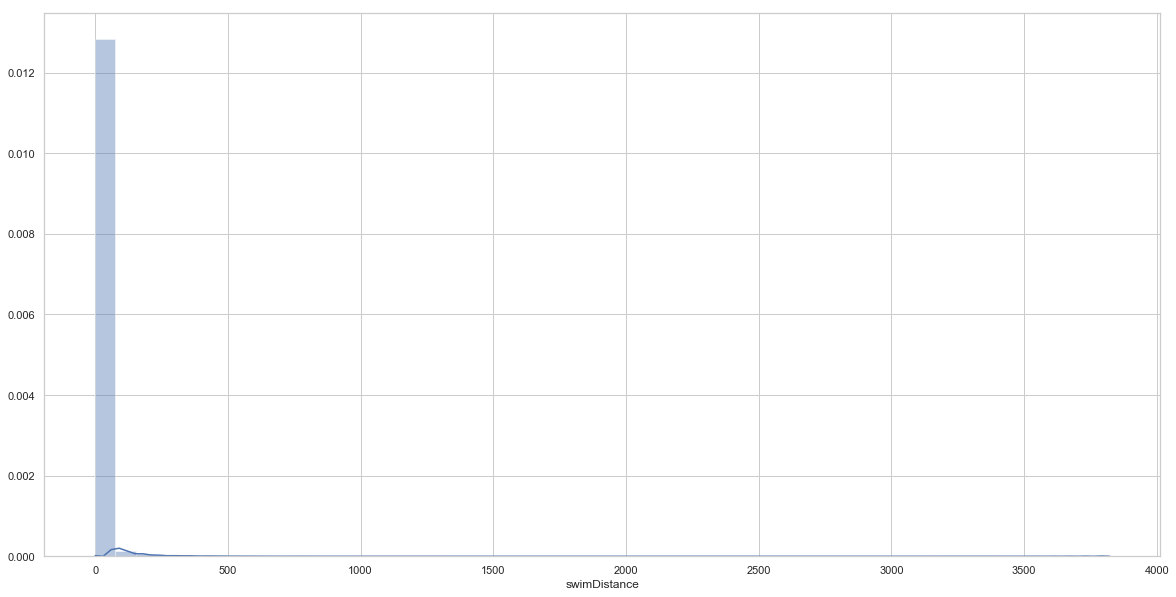

In [50]:
plt.figure(figsize=(20,10))
sns.distplot(train['swimDistance'], bins=50)

In [61]:
# 99.99タイルを見つける
train['swimDistance'].quantile(0.999)

428.6401000000536

99.99%タイルが778.2540のため、とりあえず1000mを超えるようなデータはすべて削除する

In [63]:
train['swimDistance'].describe()

count    4.444600e+06
mean     4.507725e+00
std      3.049825e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.823000e+03
Name: swimDistance, dtype: float64

In [62]:
train[train['swimDistance'] >= 1000].shape

(138, 33)

In [53]:
train[train['swimDistance'] >= 1000].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killsWithoutMoving,headshot_rate
18533,d8347ac3222087,4e44ea4cdee2bd,acacd3019c559e,0,0,0.0,0,0,0,49,0,0,0,0.0,1852,solo-fpp,96,90,1633,0,6672.0,0,1171.0,0,0,914.000,2,0,0.8000,96,8757.000,False,0.0
22118,07f9b9d5902fb2,b295dcb7e8d9c1,6fbad77aefbcdf,0,0,0.0,0,0,0,45,0,0,0,0.0,1805,squad-fpp,30,27,1441,0,0.0,0,1220.0,0,0,2069.000,6,0,0.7241,94,3289.000,False,0.0
103053,de97d36ac07819,974c4035331f4c,a406a18fed67e0,0,3,228.7,0,1,0,30,1506,1,1,0.0,1364,squad-fpp,29,29,-1,0,0.0,0,1233.0,0,0,968.000,4,1551,0.8929,99,2201.000,False,1.0
136470,6bb82b3868591a,b8d975f6740b64,8c7212b87b1d67,1,1,179.5,0,0,1,39,0,0,0,0.0,1320,duo,48,45,1570,0,0.0,0,1205.0,0,0,1202.000,4,0,0.9362,93,2407.000,False,0.0
154451,3795c59bfff6cd,585a9adfeb6c30,a3ccbc309208d3,0,0,0.0,0,0,0,43,1183,0,0,0.0,1337,squad-fpp,28,25,-1,0,0.0,0,1315.0,0,0,3.209,0,1557,0.8889,96,1318.209,False,0.0


In [64]:
train.drop(train[train['swimDistance'] >= 1000.0].index, inplace=True)

In [65]:
train.shape

(4444462, 33)

#### 武器の取得数

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



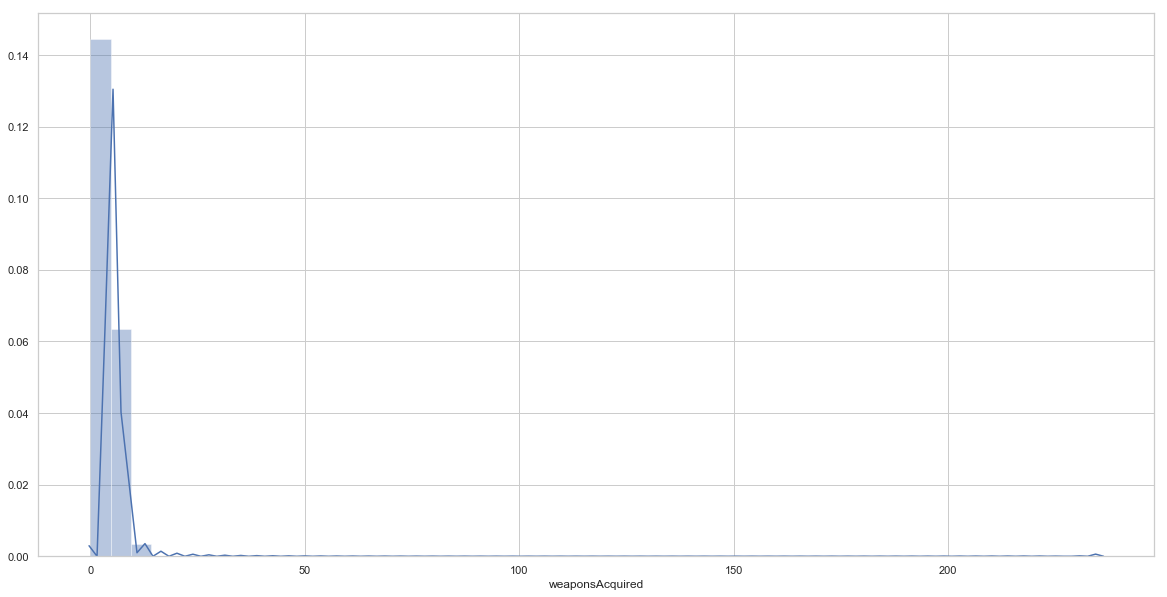

In [66]:
plt.figure(figsize=(20,10))
sns.distplot(train['weaponsAcquired'], bins=50)

In [67]:
train['weaponsAcquired'].describe()

count    4.444462e+06
mean     3.655806e+00
std      2.431533e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      2.360000e+02
Name: weaponsAcquired, dtype: float64

In [68]:
train['weaponsAcquired'].quantile(0.999)

17.0

In [69]:
train[train['weaponsAcquired'] >= 80].shape

(19, 33)

In [70]:
train[train['weaponsAcquired'] >= 80].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killsWithoutMoving,headshot_rate
233643,7c8c83f5f97d0f,b33b210a52a2f8,2e8a0917a71c43,0,0,67.11,0,0,0,44,1279,0,0,0.0,1901,duo,46,45,-1,0,1880.0,0,0.00,0,0,1307.0,128,1577,0.7111,91,3187.00,False,0.000000
588387,c58e3e0c2ba678,3d3e6100c07ff0,d04dbb98249f76,0,1,175.30,1,0,2,48,0,0,0,0.0,1372,squad,29,29,1473,0,0.0,0,0.00,0,0,1687.0,80,0,0.7500,98,1687.00,False,0.000000
1437471,8f0c855d23e4cd,679c3316056de8,fbaf1b3ae1d884,1,0,100.00,0,0,0,24,0,1,1,110.6,1840,squad-fpp,29,28,1528,0,2852.0,0,47.21,0,0,2400.0,102,0,0.8929,97,5299.21,False,0.000000
1449293,db54cf45b9ed1c,898fccaeeb041d,484b4ae51fe80f,0,0,0.00,0,0,0,54,0,0,0,0.0,1330,squad-fpp,26,23,1442,0,0.0,0,0.00,0,0,653.1,95,0,0.5600,80,653.10,False,0.000000
1592744,634a224c53444e,75fa7591d1538c,f900de1ec39fa5,9,0,1726.00,0,3,0,9,0,23,2,48.4,1798,normal-solo-fpp,11,11,1500,0,1908.0,0,0.00,0,0,980.8,94,0,0.2000,11,2888.80,False,0.130435


In [71]:
train.drop(train[train['weaponsAcquired'] >= 80].index, inplace=True)

##### heals

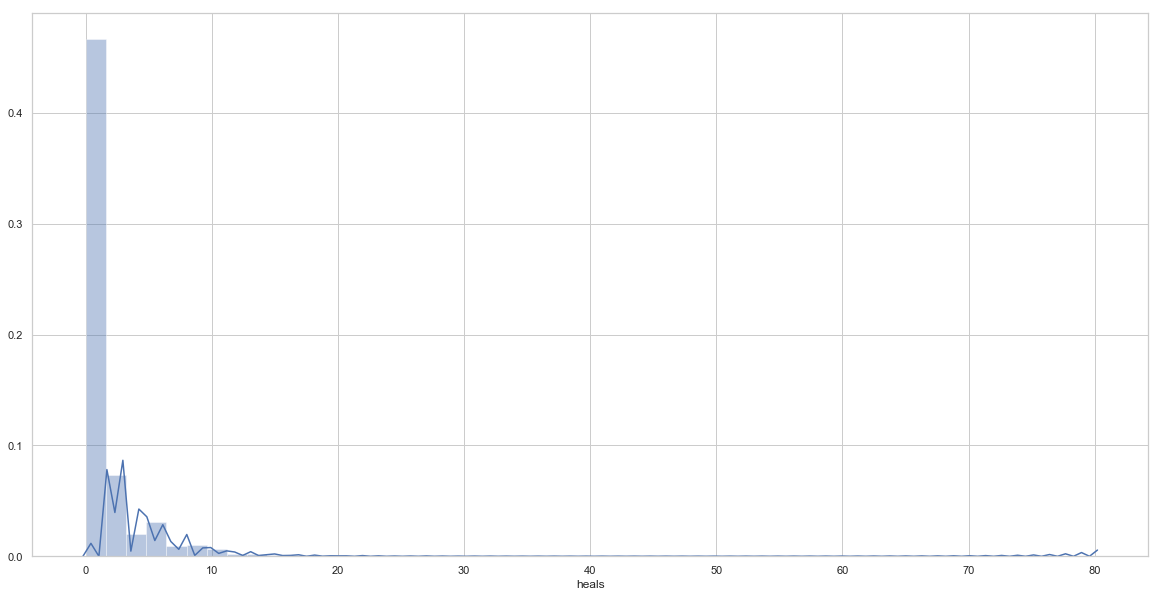

In [62]:
plt.figure(figsize=(20,10))
sns.distplot(train['heals'], bins=50)

In [63]:
train['heals'].describe()

count    4.444442e+06
mean     1.369524e+00
std      2.678885e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      8.000000e+01
Name: heals, dtype: float64

In [74]:
train[train['winPlacePerc'] > 0.9]['heals'].describe()

count    464918.000000
mean          3.363150
std           3.694861
min           0.000000
25%           1.000000
50%           2.000000
75%           5.000000
max          56.000000
Name: heals, dtype: float64

In [64]:
train['heals'].quantile(0.999)

22.0

50個以上回復アイテムを使うようなデータは外れ値として扱ったほうがよいのかは迷う  
23個程度なら、そんなにデータセットの量が多ければ80個くらいは使う人が出てもおかしくないのでは？といえるからである。  
よってここではどういうデータがあるのかを示す程度にとどめる。  

In [77]:
train[train['heals'] >= 50].shape

(23, 33)

In [76]:
train[train['heals'] >= 50].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killsWithoutMoving,headshot_rate
126439,c45bd6917146e2,81ab9f863957cb,4335664c6716fa,0,2,0.000,0,0,52,49,1331,0,0,0.000,1374,solo-fpp,97,96,-1,0,0.0,0,3.443,0,0,1340.0,3,1543,0.8333,97,1343.443,False,0.0
700615,512ca0f7c6729b,de2c3988154e5e,03a24daa0f3e65,0,3,0.000,3,0,61,48,0,0,0,0.000,1876,duo,45,44,1519,3,662.8,0,0.000,1,0,963.8,2,0,0.6364,90,1626.600,False,0.0
807030,1b1d77a24be1e1,4b83c72836d02e,109b5a0176fc3e,0,5,0.000,0,0,57,46,0,0,0,0.000,1766,solo-fpp,95,94,1525,0,2583.0,0,24.970,0,0,3003.0,5,0,0.8617,95,5610.970,False,0.0
996709,6737eed1cf8dfc,12cc81f7d2eb4d,5f9a59a3ef190d,0,6,1.824,0,0,63,37,1025,0,0,0.000,1925,solo-fpp,80,76,-1,0,3906.0,0,0.000,0,0,1752.0,4,1516,0.8481,80,5658.000,False,0.0
1171133,62f19f94637886,5cbe93968726ee,3be3bbabeb41f3,0,4,100.000,0,0,50,22,0,1,1,3.282,1916,duo-fpp,47,44,1468,0,0.0,0,0.000,0,0,3776.0,5,0,0.9783,93,3776.000,False,0.0


In [67]:
train.shape

(4444442, 33)

合計2500近くのデータセットを削除した。  
次はカテゴリカル変数についてみてみる。  
matchType というカテゴリで、そのマッチはどういう形式のマッチなのかを示す。  
例えば、1人で参加する Solo プレイ、2人でパーティを組む Duo, 最大4人(3人や2人でもいい)までのパーティをくむ Squad, またFPS視点かTPS視点か  
という違いもある。  

In [68]:
#  種類を確認する。
train['matchType'].nunique()

16

In [69]:
train['matchType'].value_counts()

squad-fpp           1755917
duo-fpp              996513
squad                626438
solo-fpp             536396
duo                  313542
solo                 181803
normal-squad-fpp      16181
crashfpp               6287
normal-duo-fpp         5397
flaretpp               2505
normal-solo-fpp        1458
flarefpp                718
normal-squad            448
crashtpp                371
normal-solo             276
normal-duo              192
Name: matchType, dtype: int64

一番多いのは squad-fpp , 4人パーティのFPS視点のモードが一番データ数が多い。  
次に多いのは duo-fpp , 2人パーティのFPS視点  
その次にsquadということがわかった。  

In [70]:
# 一番オーソドックスな、ワンホットエンコーディングを施す
train = pd.get_dummies(train, columns=['matchType'])

matchType_encoding = train.filter(regex='matchType') # regex: 正規表現
matchType_encoding.head()

,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [71]:
# groupIdとmatchIdは、オブジェクトデータではなくカテゴリデータに変換してから数値データへと変換する
train['groupId'] = train['groupId'].astype('category')
train['matchId'] = train['matchId'].astype('category')

In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4444442 entries, 0 to 4446965
Data columns (total 48 columns):
Id                            object
groupId                       category
matchId                       category
assists                       int64
boosts                        int64
damageDealt                   float64
DBNOs                         int64
headshotKills                 int64
heals                         int64
killPlace                     int64
killPoints                    int64
kills                         int64
killStreaks                   int64
longestKill                   float64
matchDuration                 int64
maxPlace                      int64
numGroups                     int64
rankPoints                    int64
revives                       int64
rideDistance                  float64
roadKills                     int64
swimDistance                  float64
teamKills                     int64
vehicleDestroys               int64
walkDist

In [73]:
train['groupId'].cat.codes.head()

0     613548
1     827515
2     843203
3    1339952
4    1757184
dtype: int32

In [74]:
train['groupId_cat'] = train['groupId'].cat.codes
train['matchId_cat'] = train['matchId'].cat.codes

# 元のカテゴリ変数である groupId, matchIdは削除する
train.drop(columns=['groupId', 'matchId'], inplace=True)

# 見てみる
train[['groupId_cat', 'matchId_cat']].head()

,groupId_cat,matchId_cat
0,613548,30085
1,827515,32751
2,843203,3143
3,1339952,45260
4,1757184,20531


In [75]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4444442 entries, 0 to 4446965
Data columns (total 48 columns):
Id                            object
assists                       int64
boosts                        int64
damageDealt                   float64
DBNOs                         int64
headshotKills                 int64
heals                         int64
killPlace                     int64
killPoints                    int64
kills                         int64
killStreaks                   int64
longestKill                   float64
matchDuration                 int64
maxPlace                      int64
numGroups                     int64
rankPoints                    int64
revives                       int64
rideDistance                  float64
roadKills                     int64
swimDistance                  float64
teamKills                     int64
vehicleDestroys               int64
walkDistance                  float64
weaponsAcquired               int64
winPoints   

In [76]:
train.shape

(4444442, 48)

ここからデータをより詳しく調べていく。

In [77]:
# データをコピーしておく
data = train.copy()

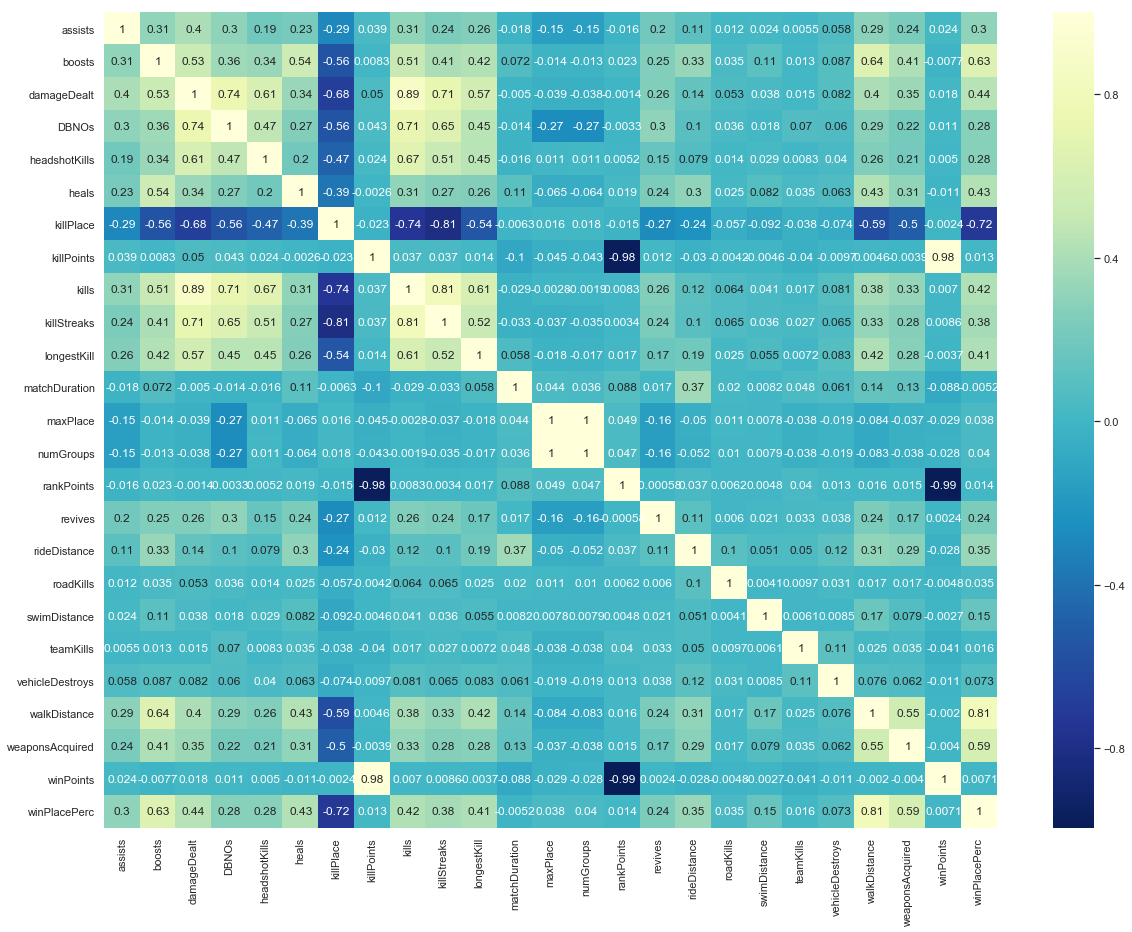

In [78]:
# まずは相関関係を確認する
plt.figure(figsize=(20,15))
sns.heatmap(train.iloc[:, :26].corr(), cmap='YlGnBu_r', annot=True)

まず、ターゲット変数と相関関係が比較的高いのは、boosts, walkDistance, weaponAcquired,damageDealt, healsあたり。  
damageDealtとkillを見てみると、強い相関関係があることがわかる。  
よって予測モデル、とりわけ線形モデルを作るときにはよりターゲット変数との相関が高いdamageDealtを残し、killsを削除するといいかもしれない。  
killsはdamageDealtよりもほかの変数との相関が高い(例えば, DBNOsやkillstreaksなといったもの)ため、線形モデルとの相性は悪い  
また、やはりwalkDistanceとは最も相関がよかった。これは、生き残るためには移動しなければならず、必然的に歩行距離が延びるためである。  
(エリア制限があり、移動しないと死ぬ)  

In [82]:
k = 5 # トップ5
cols = train.iloc[:,:26].corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index

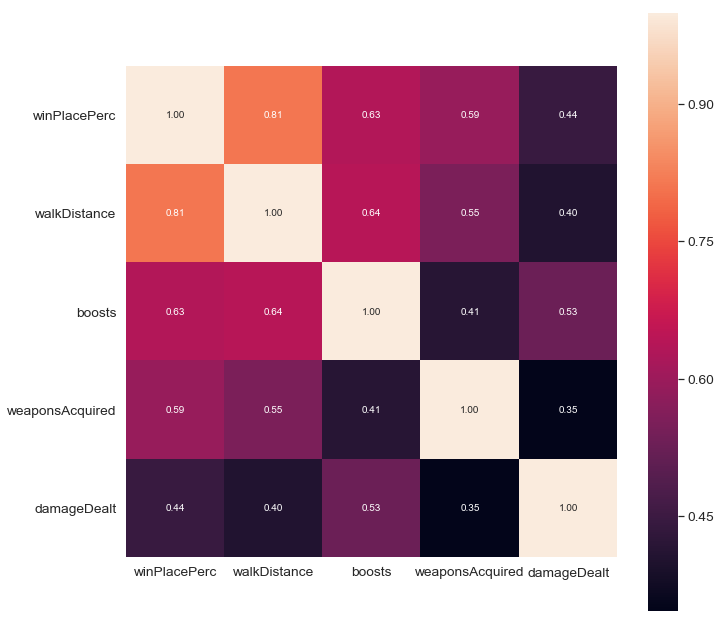

In [83]:
# ↑の図は全体を表し、どの特徴量がターゲット変数と相関が高いのかわかりづらいため、相関が高い上位のヒートマップを図示する。
f,ax = plt.subplots(figsize=(11, 11))
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning:

The `size` parameter has been renamed to `height`; pleaes update your code.



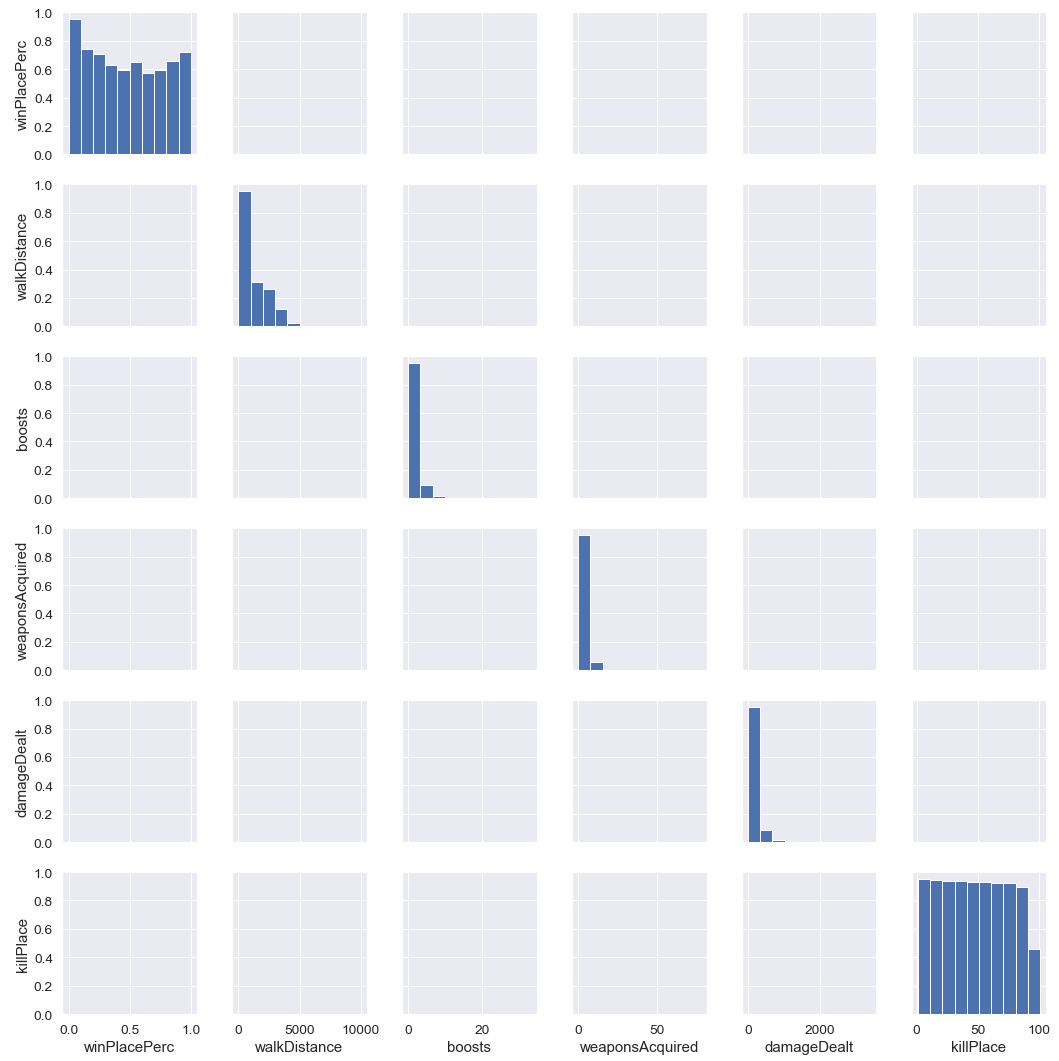

In [86]:
# ターゲット変数との相関の上位5位を使って相関関係をより詳しく見てみる
cols = ['winPlacePerc', 'walkDistance', 'boosts', 'weaponsAcquired', 'damageDealt', 'killPlace']
sns.pairplot(train[cols], size=2.5)

In [ ]:
# プレイヤーのキル数が大体どのくらいなのか調べていく
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(20,10))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title('Kill Count', fontsize=15)

多くののプレイヤーが0kill, すなわち誰もキルしていないことがわかる。  
じゃあそのうち、どのくらいのダメージなら与えられたのか調べる。  

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



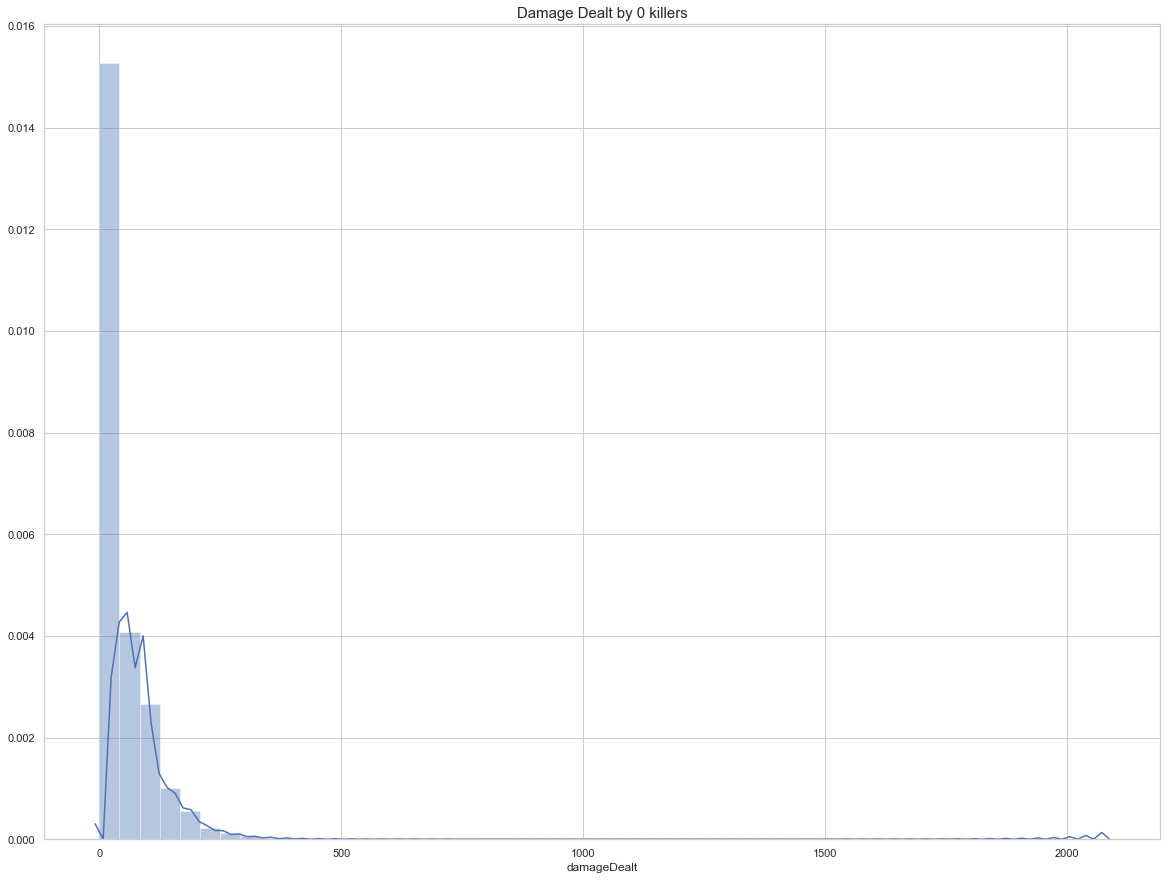

In [85]:
data = train.copy()
data = data[data['kills'] == 0]
plt.figure(figsize=(20,15))
plt.title('Damage Dealt by 0 killers', fontsize=15)
sns.distplot(data['damageDealt'])

ダメージを2000以上与えているにも関わらずだれも倒せていない人がいることがわかる。  
また、ほとんどのほとんどのプレイヤーはそもそもダメージを与えられていない、という結果になった。  
次は kills と ターゲット変数 winPlacePercの相関を調べてみる  

##### plt.figure(figsize=(15,10))
sns.jointplot(x='winPlacePerc', y='kills', data=train, height=10, ratio=3, color='b')

やはり kills と winPlacePerc との間には相関関係があることがわかる。  
killsがとりわけ多くなくても生き残っているプレイヤーも多いが、  
多いプレイヤー, 30を超えてくるようなプレイヤーは上位40%以上に食い込んでいる。  
kill数に基づくグルーピングをしてみる  

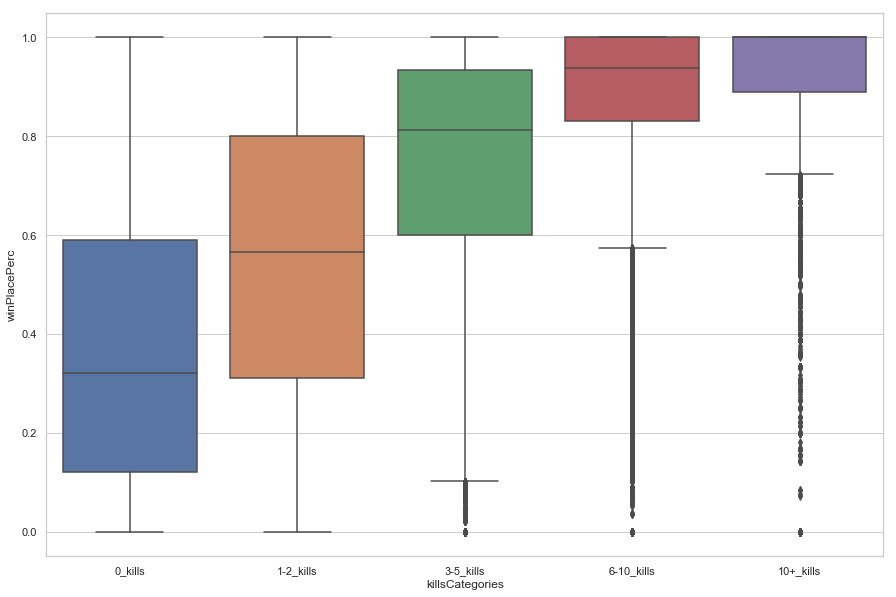

In [87]:
kills = train.copy()
kills['killsCategories']= pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 30], labels=['0_kills', '1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,10))
sns.boxplot(x='killsCategories', y='winPlacePerc', data=kills)

#### walkDistance

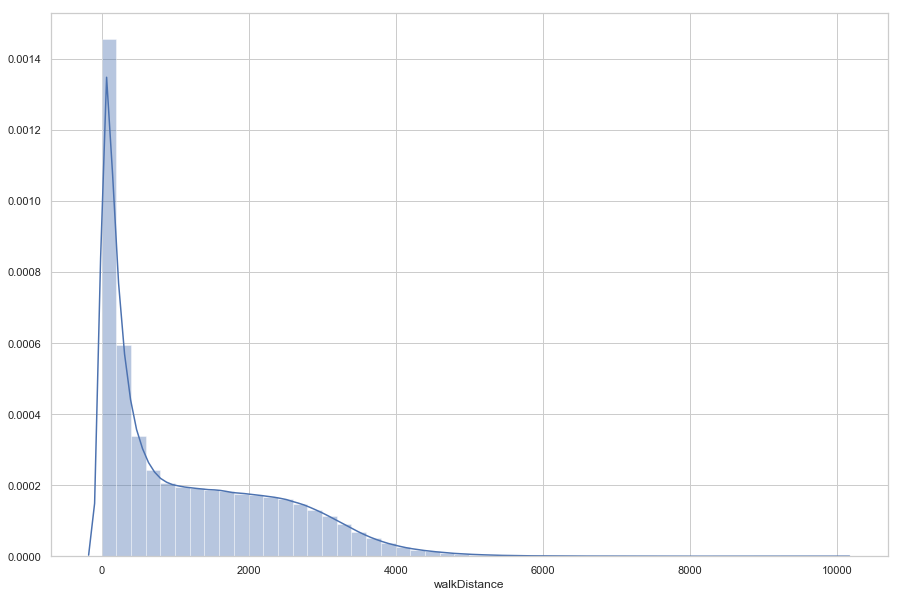

In [98]:
# 分布
plt.figure(figsize=(15,10))
sns.distplot(train['walkDistance'], bins=50)

In [96]:
# 驚くべきことだが、まったく動かないまま終了しているプレイヤーが多い。
# 移動距離が0mのプレイヤーが何人いるかみてみる
len(train[train['walkDistance'] == 0])

98067

約100000ものプレイヤーは動かないで終了している。 AFKなのか本当に動かず死んだのか。。。

<Figure size 1080x720 with 0 Axes>

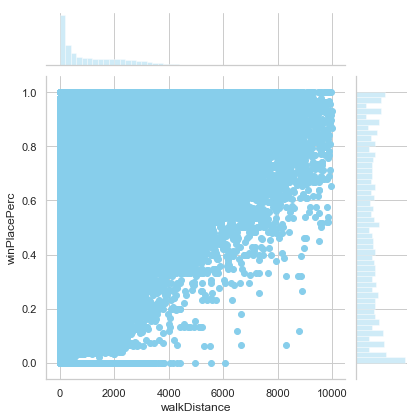

In [100]:
plt.figure(figsize=(15,10))
sns.jointplot(x='walkDistance', y='winPlacePerc', data=train, color='skyblue')

ここで気づいたのだが、まったく動かずに生き残るすなわちwinPlacePercが1.0になるということは実情不可能だと思われる。  
ただ、もしマッチのプレイヤー人数が少なければ可能性はあるかもしれないので、ここでは  
まったく動かずに winPlacePercが1.0かつ参加プレイヤー数が60以上であるようなデータは不正の可能性も高いため、削除する。  

In [105]:
train[(train['walkDistance'] == 0) & (train['winPlacePerc'] == 1.0) & (train['playersJoined'] >= 60)]

,Id,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killsWithoutMoving,headshot_rate,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,groupId_cat,matchId_cat
120666,343a30631b578f,0,0,0.00,0,0,0,50,1014,0,0,0.0,1468,27,26,-1,0,0.0,0,3.3120,0,0,0.0,0,1502,1.0,99,3.3120,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1536847,12148
461500,8c2e94f8d2a884,0,0,0.00,0,0,0,40,0,0,0,0.0,1541,31,30,1589,0,0.0,0,0.0000,0,0,0.0,0,0,1.0,95,0.0000,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1097027,21081
519969,7f50eaf7acb49c,0,0,0.00,0,0,0,39,1050,0,0,0.0,1878,29,28,-1,0,0.0,0,0.0000,0,0,0.0,0,1537,1.0,95,0.0000,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1681812,6816
685454,1baf5555b893bf,0,0,0.00,0,0,0,64,0,0,0,0.0,896,27,18,1500,0,0.0,0,0.0000,0,0,0.0,4,0,1.0,74,0.0000,False,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,338925,37857
896006,12cdac620fb7fa,0,0,0.00,0,0,0,66,0,0,0,0.0,808,10,10,1500,0,0.0,0,0.0000,0,0,0.0,14,0,1.0,72,0.0000,False,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1839880,23151
941154,1690d20f1d8d52,2,1,127.60,2,0,5,70,0,0,0,0.0,1021,12,12,1500,1,0.0,0,0.0000,0,0,0.0,6,0,1.0,86,0.0000,False,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,725759,17879
1190582,52b2b122d60f27,0,0,0.00,0,0,0,44,1213,0,0,0.0,1303,27,27,0,0,0.0,0,0.0000,0,0,0.0,0,1448,1.0,93,0.0000,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1774324,5513
1407072,c2b6e98b181cc0,0,0,0.00,0,0,0,35,1237,0,0,0.0,1362,29,25,-1,0,0.0,0,0.0000,0,0,0.0,1,1540,1.0,88,0.0000,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1805201,9436
1415433,13ccae63b5d101,0,0,0.00,0,0,0,42,1225,0,0,0.0,1309,28,28,-1,0,0.0,0,0.0000,0,0,0.0,1,1530,1.0,96,0.0000,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,983358,10723
2267500,fa5ab8006fb3df,2,0,140.60,0,0,0,54,0,0,0,0.0,471,8,8,1500,0,0.0,0,0.0000,0,0,0.0,10,0,1.0,61,0.0000,False,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,319833,40852


In [106]:
train.drop(train[(train['walkDistance'] == 0) & (train['winPlacePerc'] == 1.0) & (train['playersJoined'] >= 60)].index, inplace=True)

In [107]:
train[(train['walkDistance'] == 0) & (train['winPlacePerc'] == 1.0) & (train['playersJoined'] >= 60)]

,Id,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killsWithoutMoving,headshot_rate,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,groupId_cat,matchId_cat


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



<Figure size 1080x720 with 0 Axes>

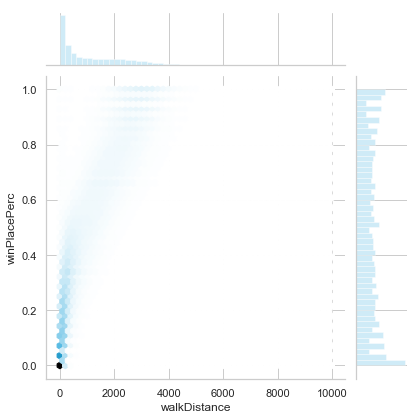

In [109]:
plt.figure(figsize=(15,10))
sns.jointplot(x='walkDistance', y='winPlacePerc', kind='hex', data=train, color='skyblue')

#### rideDistance

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



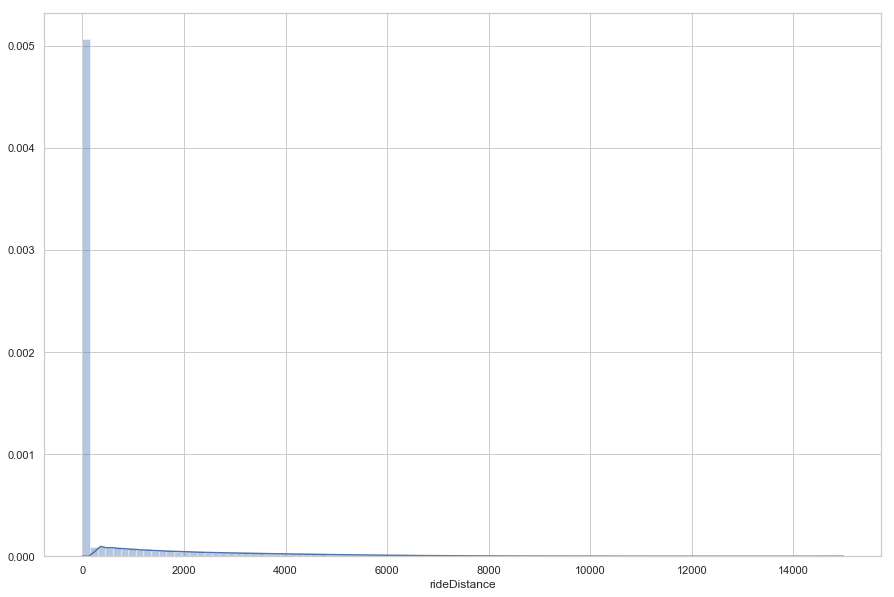

In [113]:
plt.figure(figsize=(15,10))
sns.distplot(train['rideDistance'], bins=100)

#### swimDistance

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



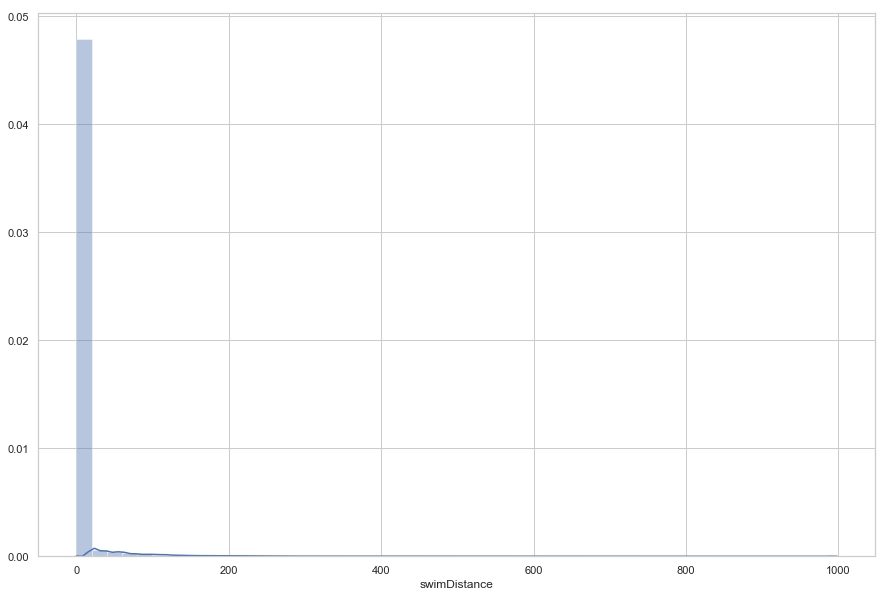

In [110]:
plt.figure(figsize=(15,10))
sns.distplot(train['swimDistance'], bins=50)

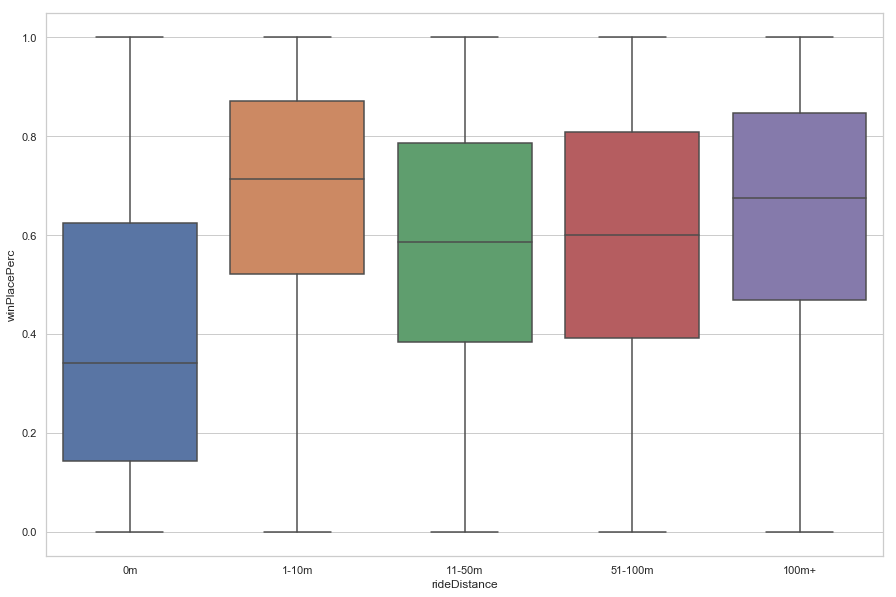

In [115]:
ride = train.copy()
ride['rideDistance'] = pd.cut(ride['rideDistance'], [-1, 0, 10, 50, 100, 500], labels=['0m', '1-10m', '11-50m', '51-100m', '100m+'])

plt.figure(figsize=(15,10))
sns.boxplot(x='rideDistance', y='winPlacePerc', data=ride)

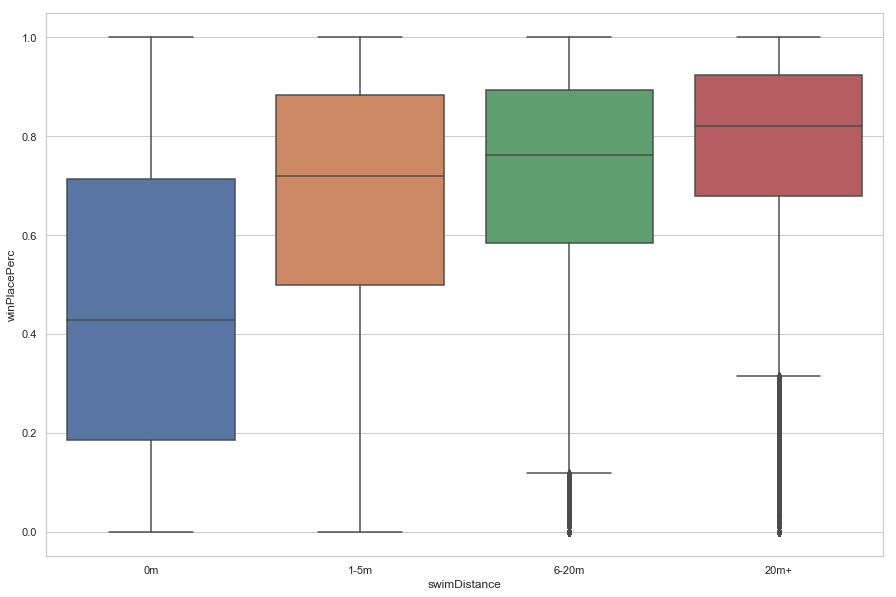

In [112]:
swim = train.copy()
swim['swimDistance'] = pd.cut(swim['swimDistance'], [-1, 0, 5, 20, 5286], labels=['0m', '1-5m', '6-20m', '20m+'])

plt.figure(figsize=(15,10))
sns.boxplot(x='swimDistance', y='winPlacePerc', data=swim)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



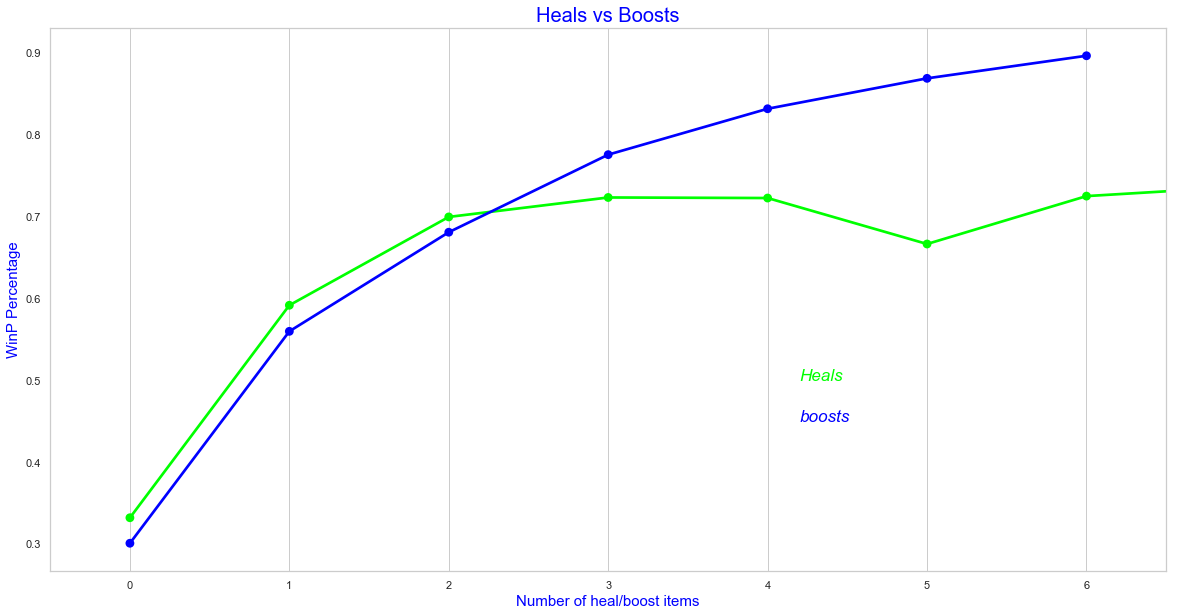

In [78]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f, ax1 = plt.subplots(figsize=(20,10))
sns.pointplot(x='heals', y='winPlacePerc', data=data, color='lime', alpha=0.7)
sns.pointplot(x='boosts', y='winPlacePerc', data=data, color='blue', alpha=0.7)
plt.text(4.2, 0.5, 'Heals', color='lime', fontsize=17, style='italic')
plt.text(4.2, 0.45, 'boosts', color='blue', fontsize=17, style='italic')

plt.xlabel('Number of heal/boost items', fontsize=15, color='blue')
plt.ylabel('WinP Percentage', fontsize=15, color='blue')
plt.title('Heals vs Boosts', fontsize=20, color='blue')
plt.grid()

<Figure size 1080x720 with 0 Axes>

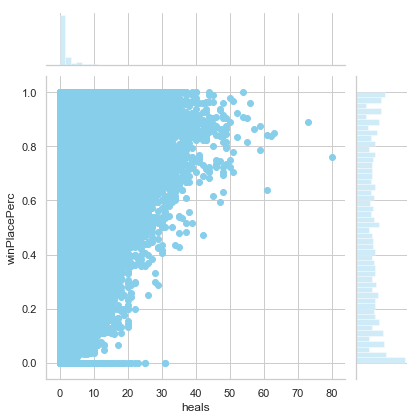

In [118]:
plt.figure(figsize=(15,10))
sns.jointplot(x='heals', y='winPlacePerc', data=train, color='skyblue')

<Figure size 1080x720 with 0 Axes>

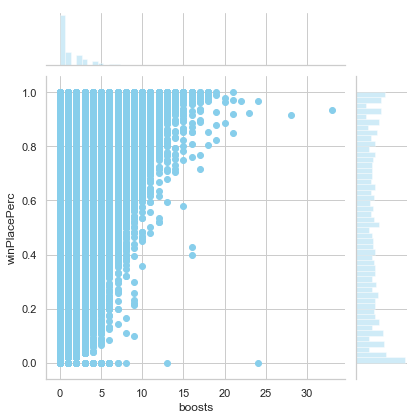

In [119]:
plt.figure(figsize=(15,10))
sns.jointplot(x='boosts', y='winPlacePerc', data=train, color='skyblue')

ここで、boostsもhealsもどちらもターゲット変数と相関がみられるため、またこれらは同じような特徴量のため、  
これらを1つにまとめて1つの特徴量とするのもいいかもしれない

In [87]:
train['healsAndBoosts'] = train['heals'] + train['boosts']